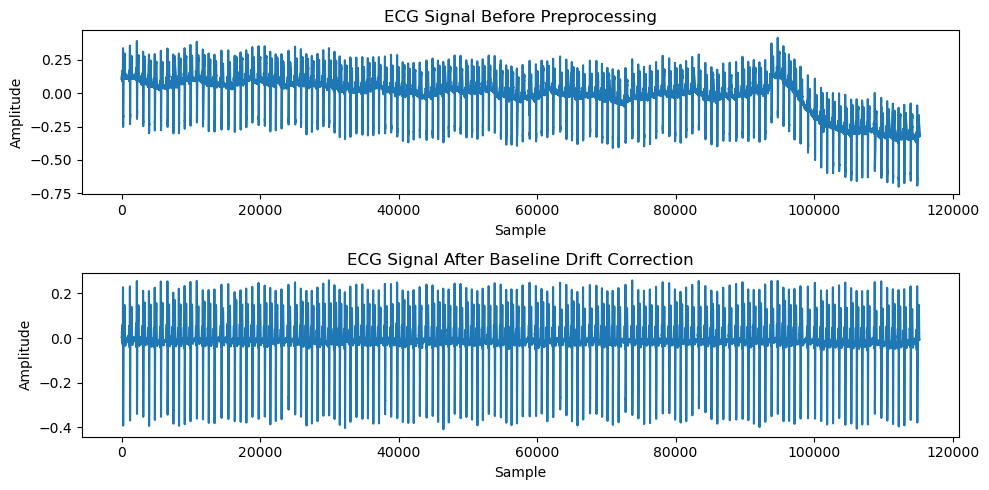

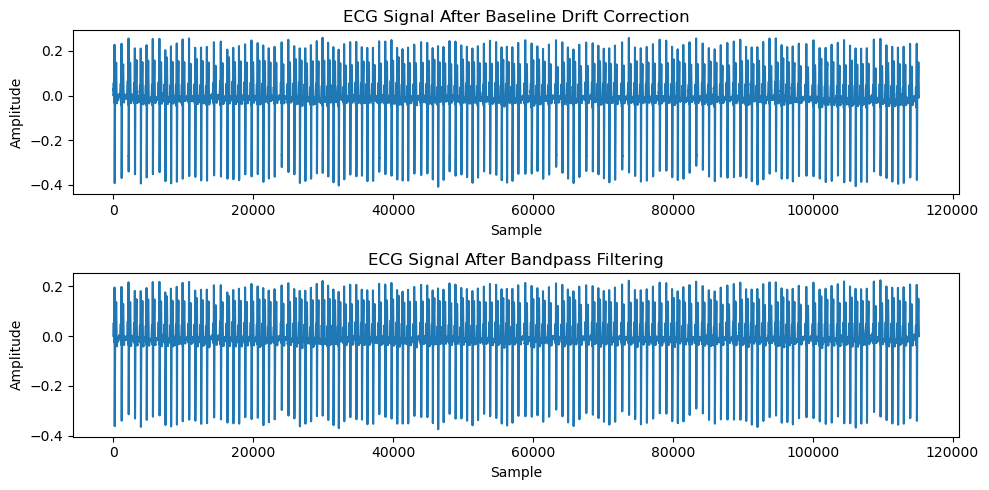

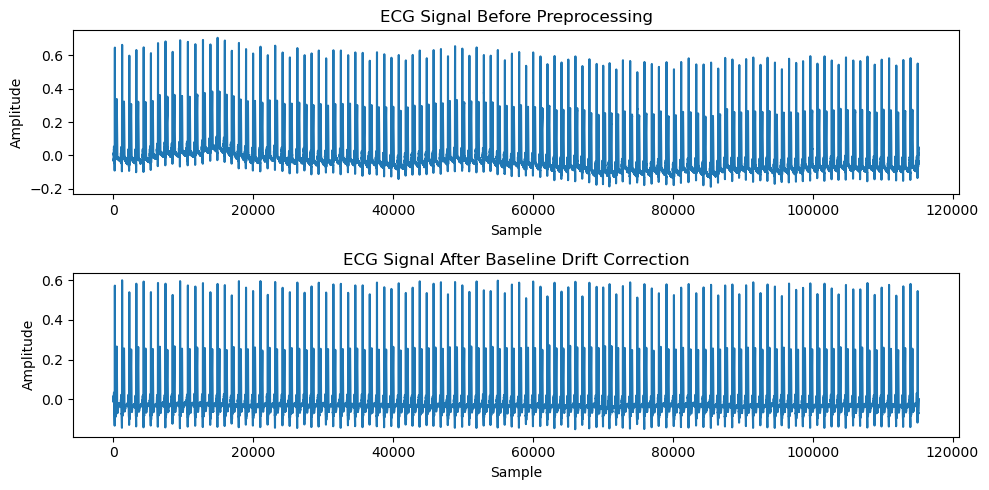

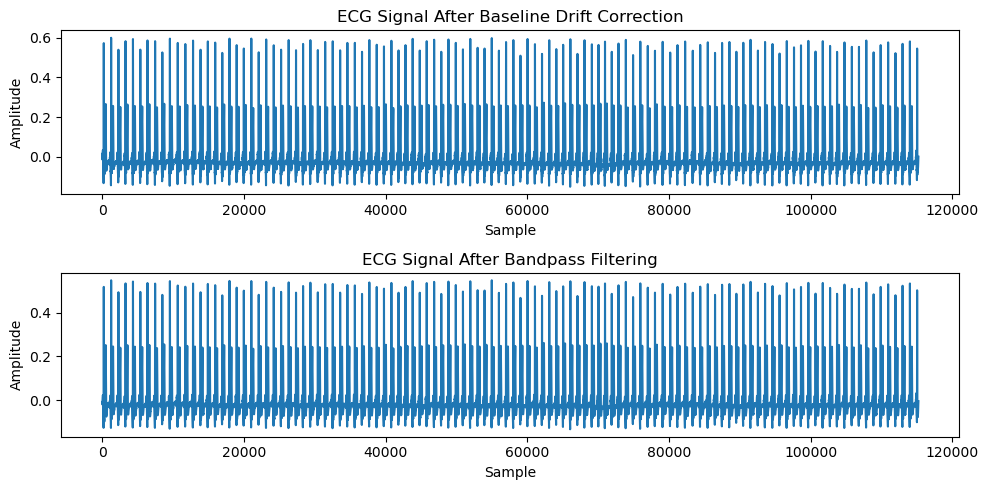

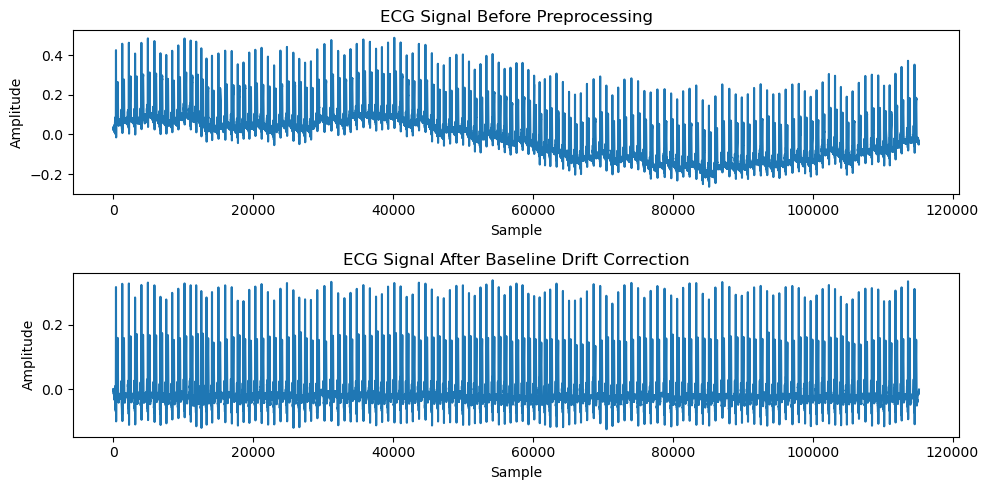

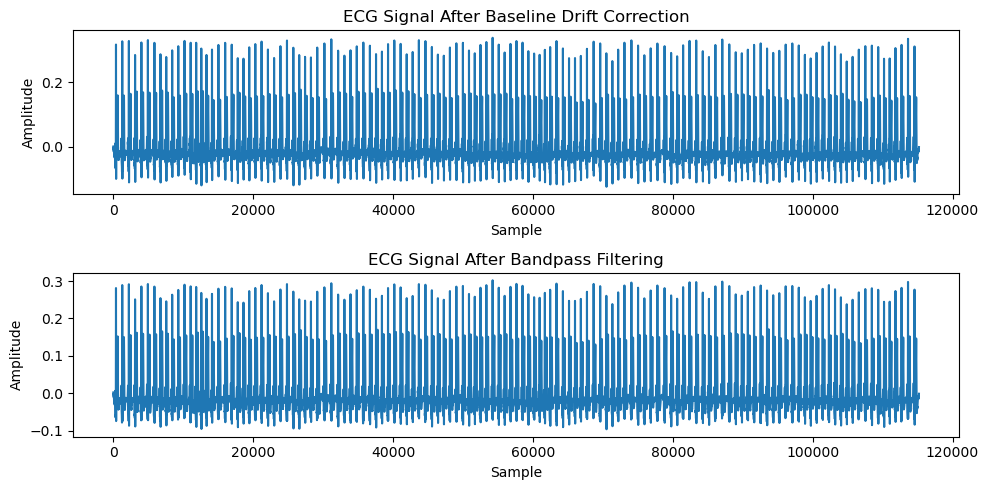

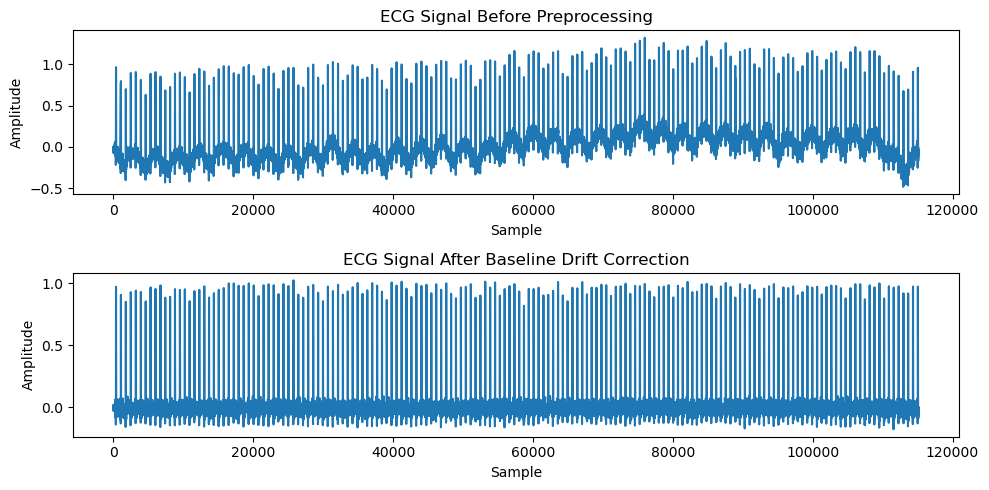

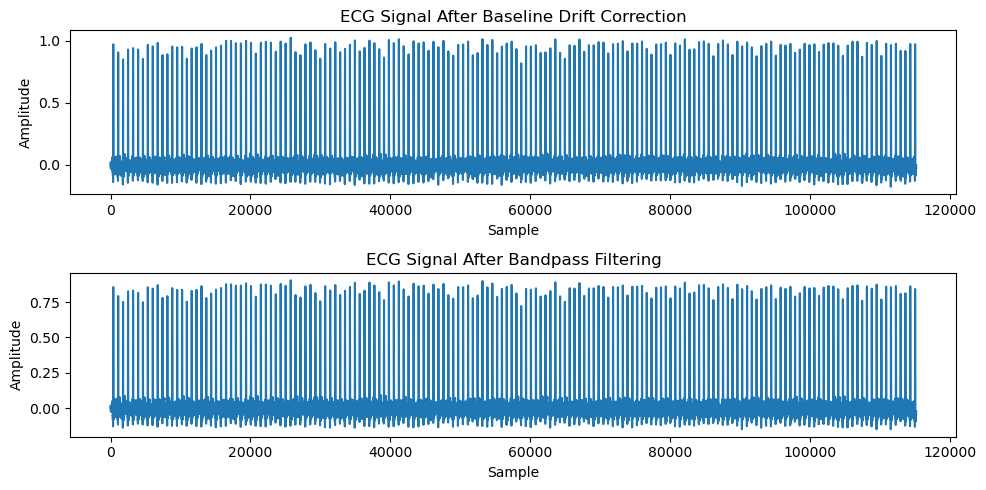

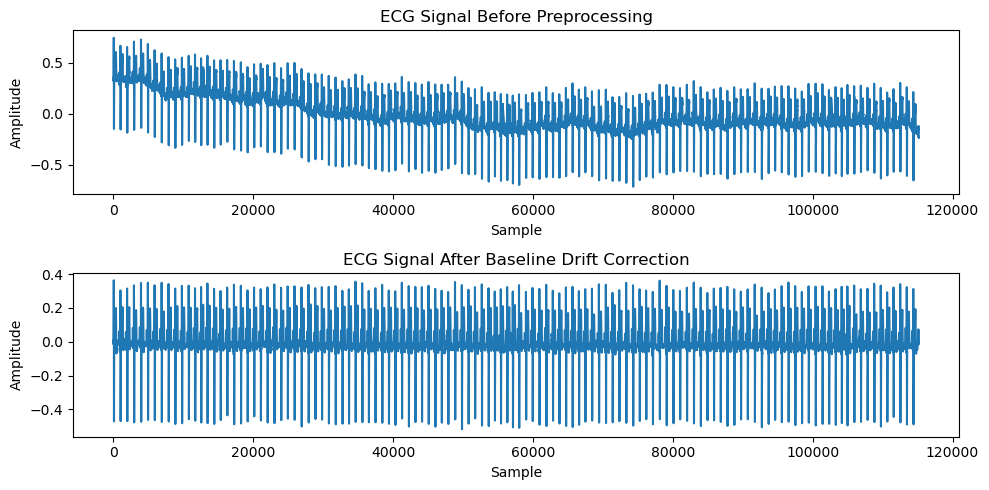

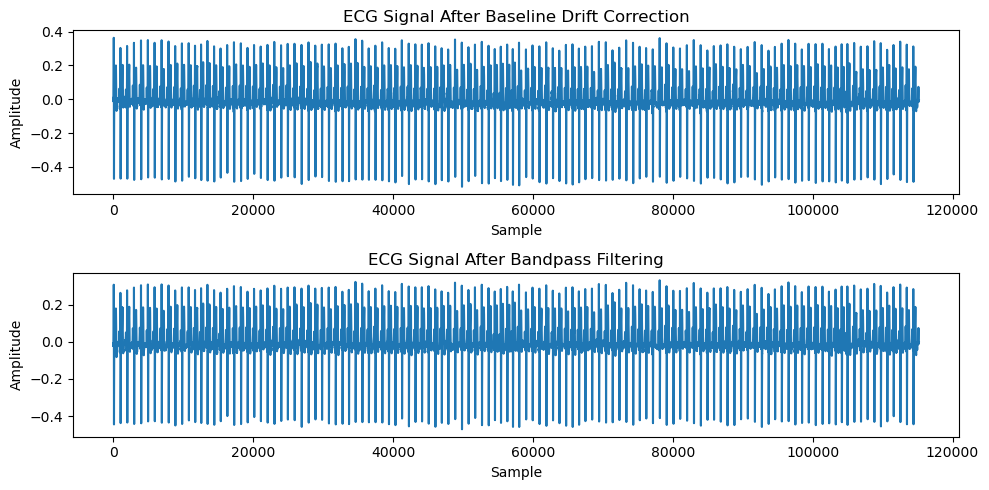

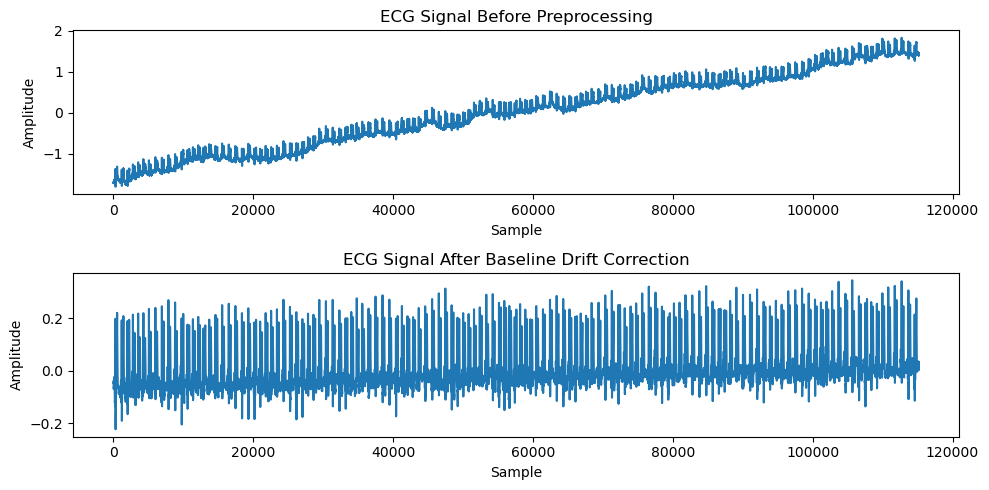

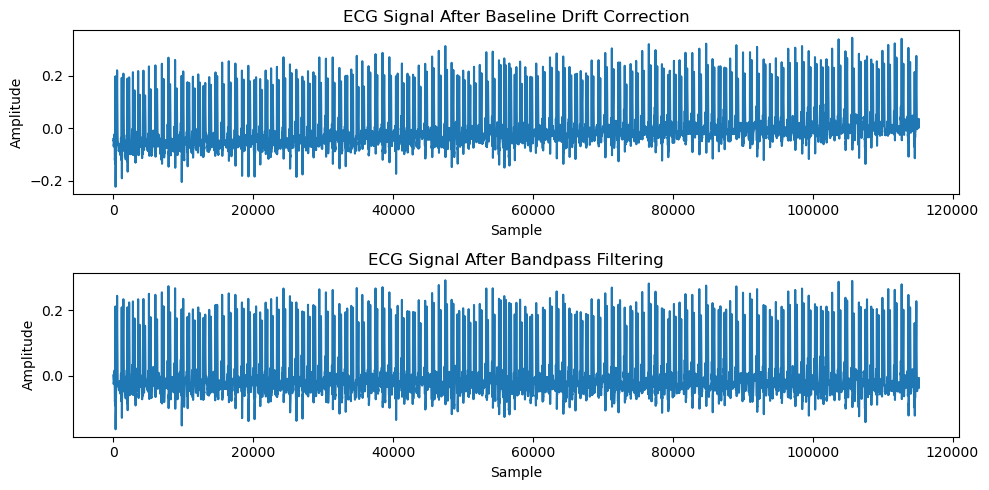

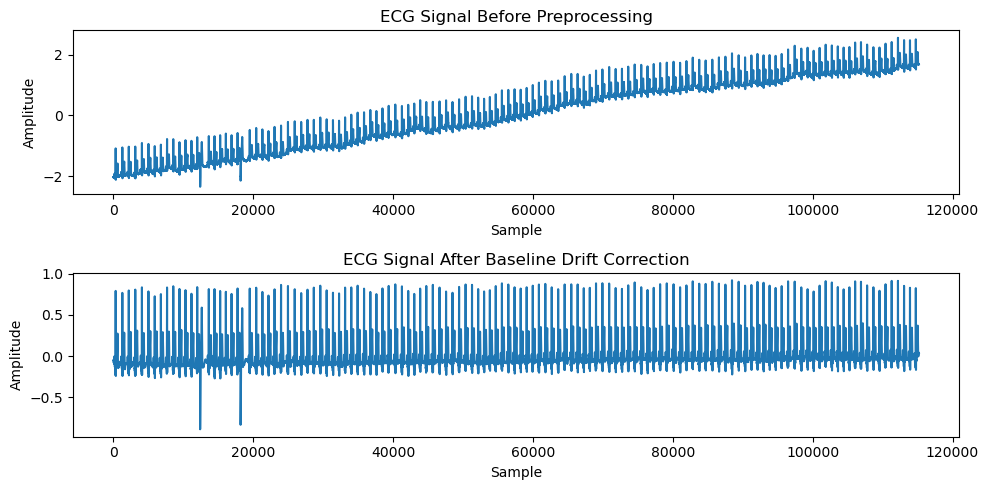

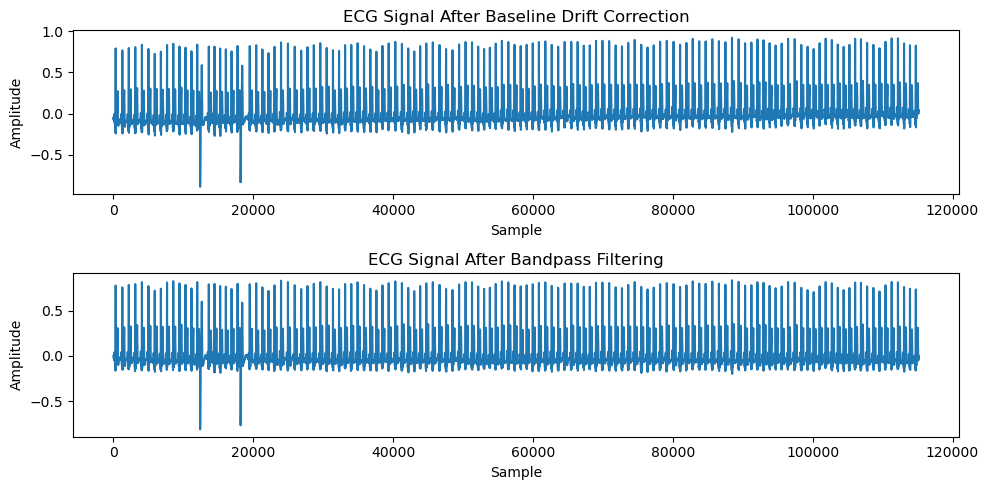

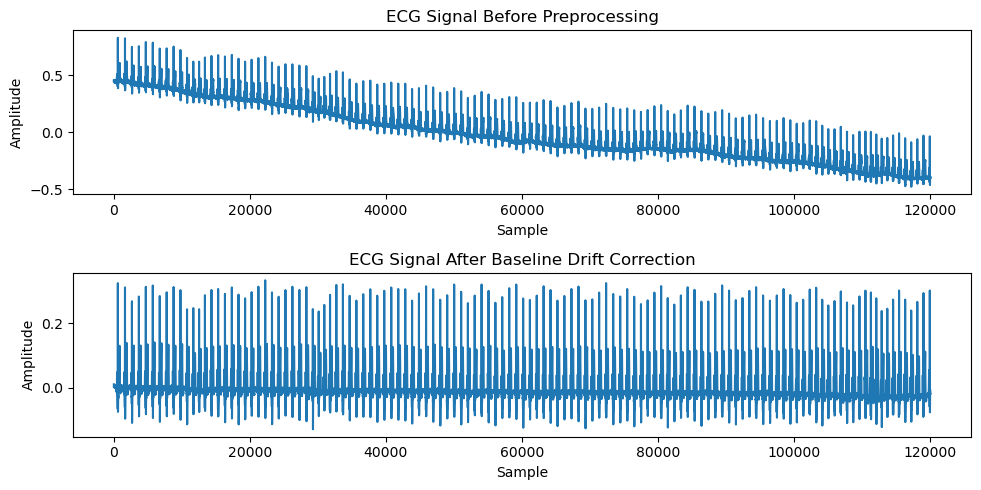

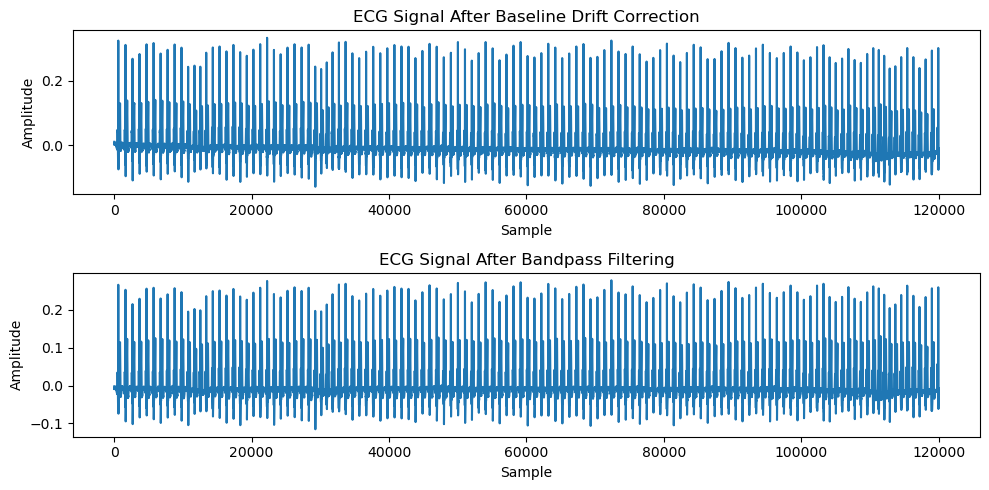

In [1]:
from tkinter import Tk, Label
from PIL import Image, ImageTk
import wfdb
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from biosppy.signals import ecg

# Paths to the ECG data for the subjects
subjects = {
    's2': r'subjects\p_156\s0299lre',
    's3': r'subjects\p_165\s0322lre',
    's5': r'subjects\p_180\s0374lre',
    's7': r'subjects\p_184\s0363lre',
    's8': r'subjects\p_185\s0336lre',
    's9': r'subjects\p_198\s0402lre',
    's10': r'subjects\sub_150\s0287lre',
    's13': r'subjects\sub260\s0496_re'
}

def load_ecg(subject_path):
    record = wfdb.rdrecord(subject_path)
    ecg_signal = record.p_signal[:, 0]  # Assuming the first channel is used
    return ecg_signal

def preprocess_with_drift_correction(ecg_signal):
    # Plot ECG signal before preprocessing
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(ecg_signal)
    plt.title('ECG Signal Before Preprocessing')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    # Apply baseline drift correction
    corrected_ecg = ecg.ecg(signal=ecg_signal, sampling_rate=1000, show=False)
    corrected_signal = corrected_ecg['filtered']

    # Plot ECG signal after baseline drift correction
    plt.subplot(2, 1, 2)
    plt.plot(corrected_signal)
    plt.title('ECG Signal After Baseline Drift Correction')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
    # Apply bandpass filtering
    nyquist = 0.5 * 1000
    low = 0.5 / nyquist
    high = 45 / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_ecg = filtfilt(b, a, corrected_signal)
    
    # Plot ECG signal after bandpass filtering
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(corrected_signal)
    plt.title('ECG Signal After Baseline Drift Correction')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(filtered_ecg)
    plt.title('ECG Signal After Bandpass Filtering')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
    return filtered_ecg

ecg_data = {subject: preprocess_with_drift_correction(load_ecg(path)) for subject, path in subjects.items()}


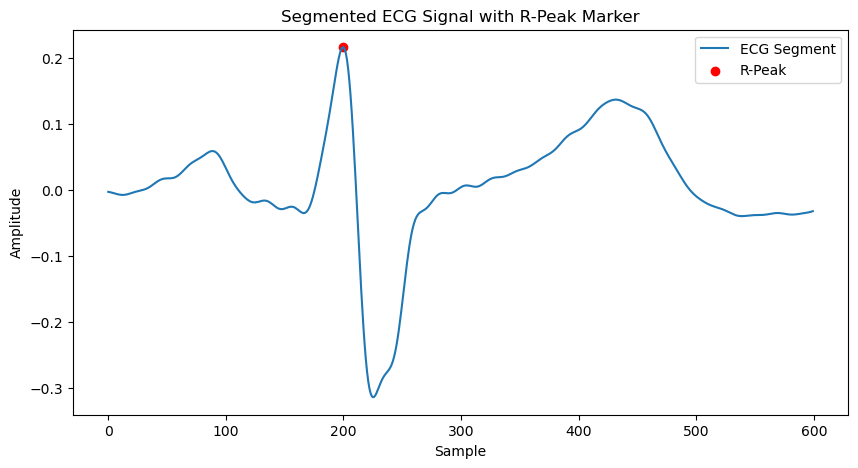

In [3]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def segment_ecg_with_threshold(ecg_signal, segment_length=600, threshold=None):
    # Find R-peaks with threshold
    peaks, _ = find_peaks(ecg_signal, height=threshold, distance=200)
    
    if len(peaks) == 0:
        raise ValueError("No peaks found with the given threshold.")
    
    # Use the first detected peak for segmentation
    peak = peaks[0]
    pre_peak_length = segment_length // 3
    post_peak_length = segment_length - pre_peak_length
    start = max(0, peak - pre_peak_length)
    end = start + segment_length
    
    if end > len(ecg_signal):
        raise ValueError("Segment exceeds signal length.")
    
    segment = ecg_signal[start:end]
    peak_in_segment = peak - start
    return segment, peak_in_segment

def plot_segment_with_peak(segment, peak_in_segment):
    plt.figure(figsize=(10, 5))
    plt.plot(segment, label='ECG Segment')
    plt.scatter([peak_in_segment], [segment[peak_in_segment]], color='red', label='R-Peak')
    plt.title('Segmented ECG Signal with R-Peak Marker')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example ECG signal
ecg_signal = ecg_data['s2']  # Replace 's2' with the subject you want to visualize

# Segment and visualize the ECG signal
segment, peak_in_segment = segment_ecg_with_threshold(ecg_signal, threshold=0.2)
plot_segment_with_peak(segment, peak_in_segment)


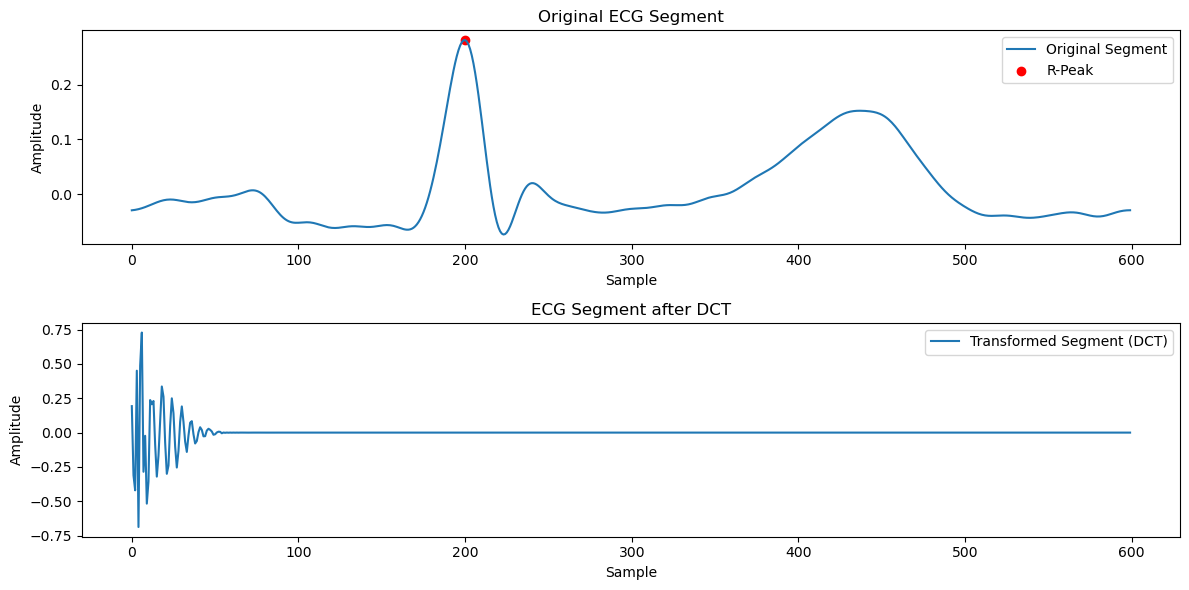

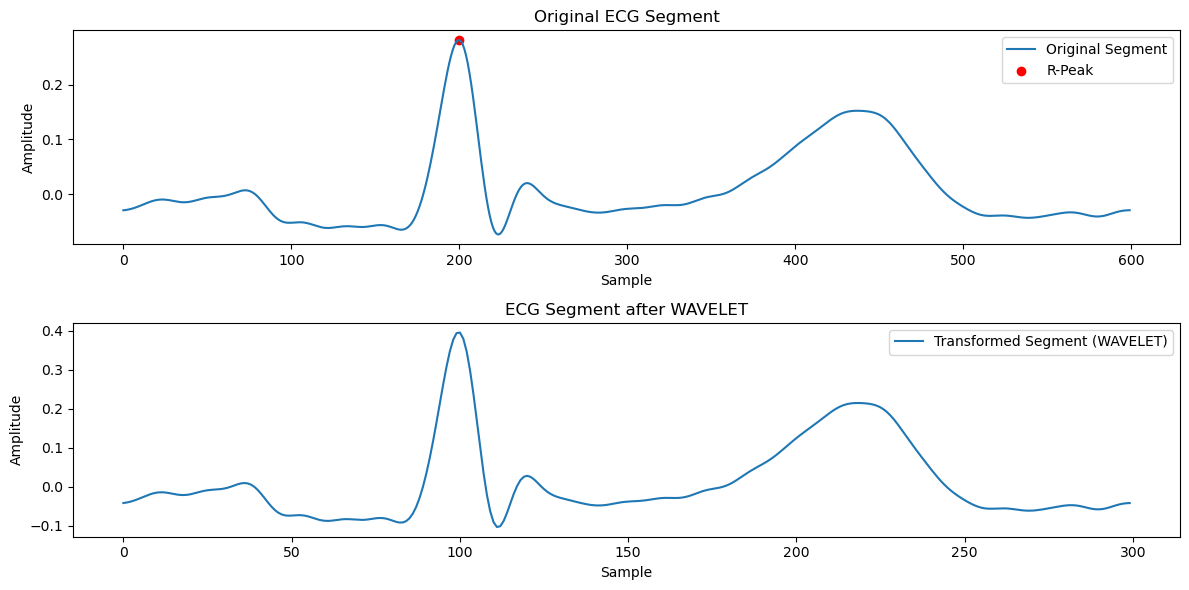

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fftpack import dct
import pywt

# Function to extract features using DCT or Wavelet Transform
def extract_features(segment, method='dct'):
    if method == 'dct':
        return dct(segment, norm='ortho')
    elif method == 'wavelet':
        coeffs, _ = pywt.dwt(segment, 'db1')
        return coeffs

# Function to plot original and transformed segments
def plot_original_and_transformed(segment, peak_in_segment, method='dct'):
    transformed_segment = extract_features(segment, method=method)
    
    plt.figure(figsize=(12, 6))
    
    # Plot original segment
    plt.subplot(2, 1, 1)
    plt.plot(segment, label='Original Segment')
    plt.scatter([peak_in_segment], [segment[peak_in_segment]], color='red', label='R-Peak')
    plt.title('Original ECG Segment')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot transformed segment
    plt.subplot(2, 1, 2)
    plt.plot(transformed_segment, label=f'Transformed Segment ({method.upper()})')
    plt.title(f'ECG Segment after {method.upper()}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example ECG signal
ecg_signal = ecg_data['s5']  # Replace 's2' with the subject you want to visualize

# Segment the ECG signal and visualize
segment, peak_in_segment = segment_ecg_with_threshold(ecg_signal, threshold=0.2)

# Plot original and transformed segments
plot_original_and_transformed(segment, peak_in_segment, method='dct')
plot_original_and_transformed(segment, peak_in_segment, method='wavelet')

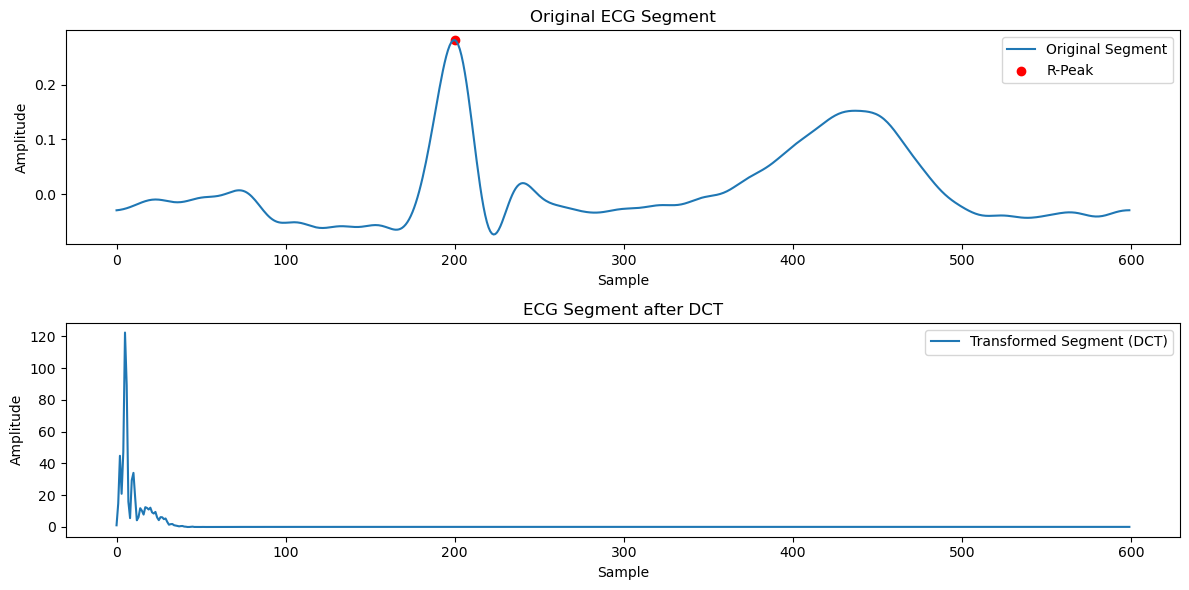

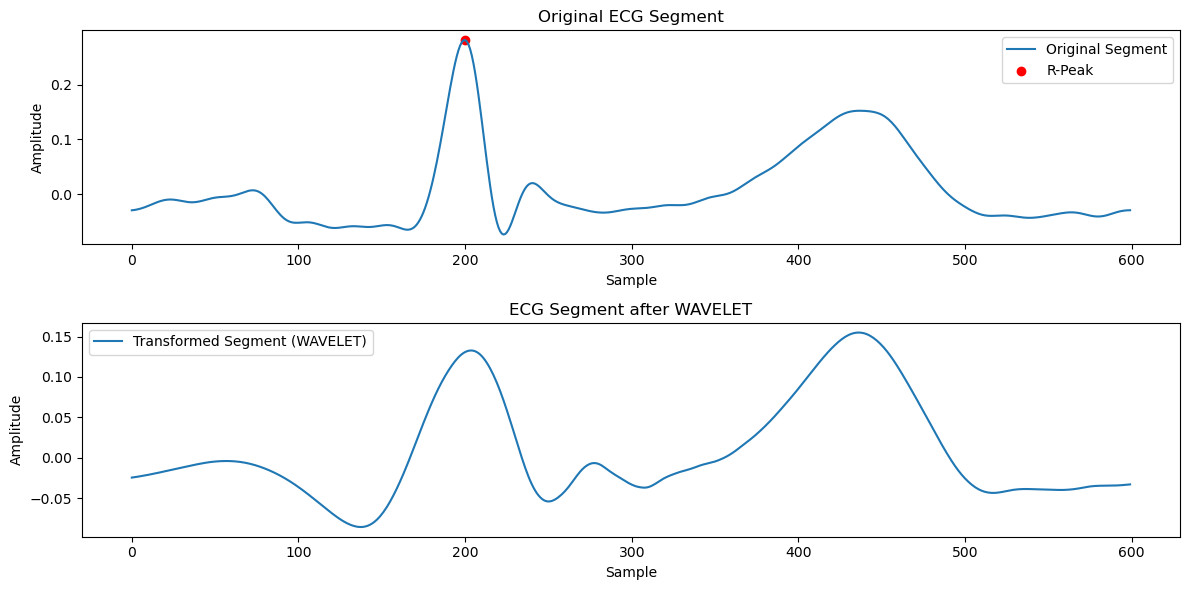

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fftpack import dct
import pywt
import statsmodels.api as sm
import scipy.fftpack
# Function to extract features using DCT or Wavelet Transform
def preprocess_using_ACDCT(filtered_signal):
    sig = np.array(filtered_signal)
    AC = sm.tsa.acf(sig, nlags=1000)
    s = AC[0:100]
    DCT = scipy.fftpack.dct(AC, type=2)
    return DCT

def preprocess_using_wavelet(filtered_signal):
    wavelet = 'db8'
    level = 5
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)
    for i in range(1, level):
        coeffs[i] = np.zeros_like(coeffs[i])  # Remove high freq components and set to 0
    res = pywt.waverec(coeffs, wavelet)  # Wave reconstruction
    return res

def extract_features(segment, method='dct'):
    if method == 'dct':
        return preprocess_using_ACDCT(segment)
    elif method == 'wavelet':
        return preprocess_using_wavelet(segment)
    else:
        raise ValueError("Unsupported method. Use 'dct' or 'wavelet'.")


# Function to plot original and transformed segments
def plot_original_and_transformed(segment, peak_in_segment, method='dct'):
    transformed_segment = extract_features(segment, method=method)
    
    plt.figure(figsize=(12, 6))
    
    # Plot original segment
    plt.subplot(2, 1, 1)
    plt.plot(segment, label='Original Segment')
    plt.scatter([peak_in_segment], [segment[peak_in_segment]], color='red', label='R-Peak')
    plt.title('Original ECG Segment')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot transformed segment
    plt.subplot(2, 1, 2)
    plt.plot(transformed_segment, label=f'Transformed Segment ({method.upper()})')
    plt.title(f'ECG Segment after {method.upper()}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example ECG signal
ecg_signal = ecg_data['s5']  # Replace 's2' with the subject you want to visualize

# Segment the ECG signal and visualize
segment, peak_in_segment = segment_ecg_with_threshold(ecg_signal, threshold=0.2)

# Plot original and transformed segments
plot_original_and_transformed(segment, peak_in_segment, method='dct')
plot_original_and_transformed(segment, peak_in_segment, method='wavelet')